In [8]:
import requests
import datetime
from urllib.parse import urlencode
from os import environ 
import base64
import urllib.request
import cv2
import matplotlib.pyplot as plt

In [2]:
client_id = environ.get('SPOTIFY_CLIENT_ID')
client_secret = environ.get('SPOTIFY_CLIENT_SECRET')

client_id = client_id
client_secret = client_secret

In [3]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')
    
    def base_search(self, query_params): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()
    
    def search(self, query=None, operator=None, operator_query=None, search_type='artist' ):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower()})
        print(query_params)

        return self.base_search(query_params)

In [4]:
spotify = SpotifyAPI(client_id, client_secret)

In [5]:
spotify.search(query = 'Ok Computer Radiohead', search_type="album")

q=Ok+Computer+Radiohead&type=album


{'albums': {'href': 'https://api.spotify.com/v1/search?query=Ok+Computer+Radiohead&type=album&offset=0&limit=20',
  'items': [{'album_type': 'album',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4Z8W4fKeB5YxbusRsdQVPb'},
      'href': 'https://api.spotify.com/v1/artists/4Z8W4fKeB5YxbusRsdQVPb',
      'id': '4Z8W4fKeB5YxbusRsdQVPb',
      'name': 'Radiohead',
      'type': 'artist',
      'uri': 'spotify:artist:4Z8W4fKeB5YxbusRsdQVPb'}],
    'available_markets': ['AD',
     'AE',
     'AG',
     'AL',
     'AM',
     'AR',
     'AT',
     'AU',
     'AZ',
     'BA',
     'BB',
     'BD',
     'BE',
     'BF',
     'BG',
     'BH',
     'BI',
     'BN',
     'BO',
     'BR',
     'BS',
     'BT',
     'BW',
     'BY',
     'BZ',
     'CA',
     'CH',
     'CL',
     'CM',
     'CO',
     'CR',
     'CV',
     'CW',
     'CY',
     'CZ',
     'DE',
     'DK',
     'DM',
     'DO',
     'DZ',
     'EC',
     'EE',
     'EG',
     'ES',
     'FI',
     'FJ'

In [16]:
%%time
spotify.search(query = 'Ok Computer Radiohead', search_type="album")['albums']['items'][0]['images']

q=Ok+Computer+Radiohead&type=album
CPU times: user 28.7 ms, sys: 5.03 ms, total: 33.8 ms
Wall time: 234 ms


[{'height': 640,
  'url': 'https://i.scdn.co/image/ab67616d0000b273c8b444df094279e70d0ed856',
  'width': 640},
 {'height': 300,
  'url': 'https://i.scdn.co/image/ab67616d00001e02c8b444df094279e70d0ed856',
  'width': 300},
 {'height': 64,
  'url': 'https://i.scdn.co/image/ab67616d00004851c8b444df094279e70d0ed856',
  'width': 64}]

In [18]:
image = spotify.search(query = 'Ok Computer Radiohead', search_type="album")['albums']['items'][0]['images'][2]['url']

q=Ok+Computer+Radiohead&type=album


In [19]:
test = urllib.request.urlretrieve(image,'test.jpg')

In [20]:
# Since cv2 reads colors as BRG, this converts it to RGB 

img1 = cv2.imread(test[0])[:,:,::-1]

In [21]:
img1

array([[[253, 253, 253],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[253, 253, 253],
        [253, 253, 253],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[250, 252, 251],
        [253, 253, 253],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[253, 253, 253],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[254, 254, 254],
        [255, 255, 255],
        [255, 253, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

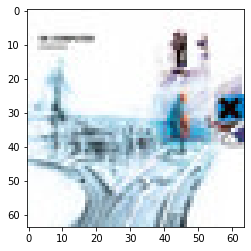

In [22]:
plt.imshow(img1)